In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, average_precision_score, accuracy_score


def prepare_time_series(df, month_array, type_operation, groupby_feature = 'user_id'):
    
    # If we want to append each month as a seperate feature 
    if type_operation == 'append':
        
        # Find the months of interest
        df_new = df[df.index.get_level_values(1).isin(month_array)].unstack().fillna(0)
        
        # Name new columns
        new_cols = [str(item[0]) + '_' + str(int(item[1])) for item in df_new.columns]
        
        # Drop level and rename
        df_new.columns = df_new.columns.droplevel(0)
        df_new.columns = new_cols
    
    # If we want to sum the values of each feature for every month
    elif type_operation == 'sum':
        df_new = df[df.index.get_level_values(1).isin(month_array)]
        df_new = df_new.reset_index().groupby(groupby_feature).sum()
    
    return df_new

In [3]:
# Inputs
source_csv = '/home/work/GitHub/data/teacher_churn/edit_teacher_timeseries.csv'
source_user = '/home/work/GitHub/data/user_info.csv'

# Reading dataframes
df = pd.read_csv(source_csv)
df_user = pd.read_csv(source_user)

# Exracting info
df_user = df_user.set_index('id')
df_user['registration_date'] = pd.to_datetime(df_user['registration_date'])
df_user['start_month'] = df_user['registration_date'].apply(lambda x:str(x.month))
df_user['start_year'] = df_user['registration_date'].apply(lambda x:x.year)
df_user = df_user[['start_month','start_year']]

# Displayign info
df_user.head()

,start_month,start_year
id,,
d94c077ad88fc2b7a1204ba16c30f93961d86ededecbb47bef25063cb4835c12,11,2015
1ef02c359b5b66b584da8d46d1f790f509eeb55b80a908b6d3c3ad4c758b216b,10,2015
eed0d25033826f9786fc61daef41f9f6c0046248254e3c348a08bcb83b11ffb1,12,2015
5937dd6ec7778da3dc7cc63303439bcc6a622da83fdf4afdadfd6586c31af1e7,11,2015
68a983c9bfca031c77b2159cf651a624a893a02cc79bdd0624effddc2d3ff699,4,2015


In [280]:
last_month = 11;

# Find users that have churned
plot_churn = df.reset_index().groupby('index')['event_leg'].max()

# Remove users that have churned before last month
plot_churn = plot_churn[plot_churn.values >= last_month]
df_lm = df.set_index(['index','event_leg']).loc[plot_churn.index.values]

# Remove rows all greater than last_month
df_lm = df_lm[df_lm.index.get_level_values(1)<=last_month]
plot_churn =plot_churn.loc[np.unique(df_lm.index.get_level_values(0).values)]

# Label those that churned at last month
label = [1 if item == last_month else 0 for item in plot_churn.values]
df_lm = df_lm.loc[plot_churn.index.values]

# CLean off any nan
df_lm = df_lm.fillna(0)

# Add rows for months that may not exist for a user and set as zero
df_lm = df_lm.unstack(level='event_leg').stack(level='event_leg',dropna=False).fillna(0)

# Display the dataframe
df_lm.head(10)

add_assig  \
index                                              event_leg              
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0              0.0   
                                                   1.0              0.0   
                                                   2.0              0.0   
                                                   3.0              0.0   
                                                   4.0              0.0   
                                                   5.0              0.0   
                                                   6.0              0.0   
                                                   7.0              0.0   
                                                   8.0              0.0   
                                                   9.0              0.0   

                                                              add_custom_assig  \
index                                              event_leg                     
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                     0.0   
                                                   1.0                     0.0   
                                                   2.0                     0.0   
                                                   3.0                     0.0   
                                                   4.0                     0.0   
                                                   5.0                     0.0   
                                                   6.0                     0.0   
                                                   7.0                     4.0   
                                                   8.0                     4.0   
                                                   9.0                     8.0   

                                                              add_user  \
index                                              event_leg             
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0             0.0   
                                                   1.0             0.0   
                                                   2.0             0.0   
                                                   3.0             0.0   
                                                   4.0             0.0   
                                                   5.0             0.0   
                                                   6.0             0.0   
                                                   7.0            25.0   
                                                   8.0             3.0   
                                                   9.0             0.0   

                                                              create_group  \
index                                              event_leg                 
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0                 0.0   
                                                   1.0                 0.0   
                                                   2.0                 0.0   
                                                   3.0                 0.0   
                                                   4.0                 0.0   
                                                   5.0                 0.0   
                                                   6.0                 0.0   
                                                   7.0                 0.0   
                                                   8.0                 0.0   
                                                   9.0                 0.0   

                                                              play_video  \
index                                              event_leg               
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726c... 0.0               8.0   
                                                   1.0               1.0   
                                              

In [281]:
# Prepare timeseries
df_lm_new = prepare_time_series(df_lm.groupby(['index','event_leg']).sum(),[0,1],'append')

# Adding features
df_lm_new = df_lm_new.join(pd.get_dummies(df_user))

df_lm_new.head()

,add_assig_0,add_assig_1,add_custom_assig_0,add_custom_assig_1,add_user_0,add_user_1,create_group_0,create_group_1,play_video_0,play_video_1,...,start_month_11,start_month_12,start_month_2,start_month_3,start_month_4,start_month_5,start_month_6,start_month_7,start_month_8,start_month_9
index,,,,,,,,,,,,,,,,,,,,,
001c6813b7449d381899502fb8f1bbbb9239a2b3d8b726cb140669288a58515b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,...,0,0,0,0,0,0,0,0,0,0
00ffec02f911cf694e8a2eff69c896bc04929211ce2b6beba1546c8acc819591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0,0,0,0,1,0,0,0,0,0
013ec643ba6b2cc30c089983f2f8392075f446fda7e0ba7852b3446ec047c6aa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0,0,1,0,0,0,0,0,0,0
018fe09d0cc44a3a17a98291cfad54f9e85eb6d9bef902c020a7284611af50cc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
0192ac23874178d1944337222aca09a7d532025200edbe4f75f2ab1f370e0af3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


(array([ 583.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   36.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

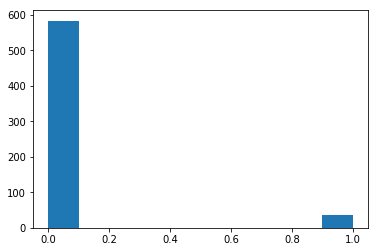

In [282]:
# Check class distribution
plt.hist(label)


[117   8]
[117   7]
[117   7]
[116   7]


/home/work/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/work/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[116   7]


,Accuracy,Precision,Recall
0,0.920000,0.0,0.0
1,0.935484,0.0,0.0
2,0.943548,0.0,0.0
3,0.943089,0.0,0.0
4,0.910569,0.0,0.0
mean,0.930538,0.0,0.0


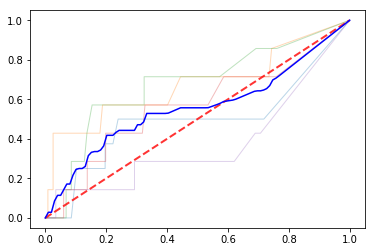

In [283]:
from scipy import interp

# Fill in any zeros
df_lm_new = df_lm_new.fillna(0)

# Assign data to auxillary variables
X = df_lm_new
y = np.array(label)

# Storing the keys
store_keys = X.keys()

# Scale the data
scaler = StandardScaler()
X_trf = scaler.fit_transform(X)
X = X_trf

# Now let's use KFolds optimisation
NUM_FOLDS = 5
kf = StratifiedKFold(n_splits = NUM_FOLDS)

score = [];
tprs = []
prec_recall=[]

mean_fpr = np.linspace(0, 1, 100)

precision = [None]*NUM_FOLDS
recall = [None]*NUM_FOLDS

it = 0;
for train_index, test_index in kf.split(X, y):
    
    # Splitting into training and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Printing distribution
    print(np.bincount(y_test))
    
    # Training and evaluating classifier
    clf = RF(n_estimators=100, random_state=42)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)
    
    # Saving values in dataframe
    score.append([accuracy_score(y_test, y_pred),precision_score(y_test, y_pred),
                    recall_score(y_test,y_pred)])
    
    # Saving values for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    
    # Plotting ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.3)
    
    # Finding precision-recall
    precision[it], recall[it], _ = precision_recall_curve(y_test, y_score[:,1], pos_label=1)
    
    it +=1
    
# Plotting luck line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

# Plotting mean and std
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
plt.plot(mean_fpr, mean_tpr, color='b')

df_score = pd.DataFrame(score, columns=['Accuracy', 'Precision','Recall'])
df_score.loc['mean'] = df_score.mean()

df_score

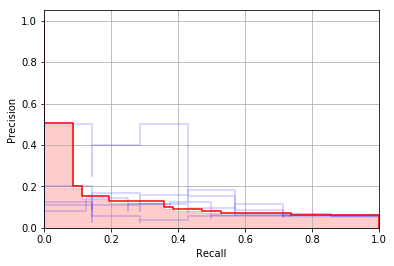

In [284]:
for item in list(zip(recall,precision)):
    #plt.plot(item[0],item[1],alpha=0.2)
    plt.step(item[0], item[1], color='b', alpha=0.2,
         where='post')
    #plt.fill_between(item[0], item[1], step='post', alpha=0.2,
     #            color='b')
        
mean_recall_prec = []

for it in range(NUM_FOLDS):
    
   mean_recall_prec.append(np.interp(np.linspace(0, 1, 100),precision[it],recall[it]))


plt.step(np.mean(mean_recall_prec, axis=0),np.linspace(0,1,100),color='r')
plt.fill_between(np.mean(mean_recall_prec, axis=0),np.linspace(0,1,100), step='post', alpha=0.2,color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid()

plt.savefig(str(last_month)+'_tch_churn.png', format='png', dpi=300)